# 1. Carga de Datos

In [39]:
# ========================================
# 1. Carga de Datos
# ========================================
import os, io, requests, pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

GH_USER   = "RobertoSam"
GH_REPO   = "Final_MetodosComputacionales"
GH_BRANCH = "main"
GH_DIR    = ""
DATA_DIR_LOCAL = "/Users/robert/Downloads/evaluacinfinalcasos"
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN", None)

def github_raw_url(filename):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{GH_BRANCH}/{GH_DIR}{filename}"

def read_csv_smart(filename, sep=",", **kwargs):
    url = github_raw_url(filename)
    try:
        headers = {"Authorization": f"token {GITHUB_TOKEN}"} if GITHUB_TOKEN else {}
        r = requests.get(url, headers=headers, timeout=30)
        r.raise_for_status()
        return pd.read_csv(io.StringIO(r.text), sep=sep, **kwargs)
    except:
        return pd.read_csv(os.path.join(DATA_DIR_LOCAL, filename), sep=sep, **kwargs)

data = read_csv_smart("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 2. Estructura del Dataset

In [43]:
# ========================================
# 2. Estructura del Dataset
# ========================================
print(data.info())
print(data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# 2.1 Corrección de Tipos de Variables e Imputación de Datos Faltantes

In [45]:
# ========================================
# 3. Corrección de Tipos de Variables e Imputación de Datos Faltantes
# ========================================

# Convertir 'TotalCharges' a numérico, manejando errores y valores faltantes
# Los valores faltantes se imputan con la mediana
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print("Valores faltantes en TotalCharges antes de imputación:\n", data['TotalCharges'].isnull().sum())
# Corrected syntax for fillna without inplace=True
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())
print("Valores faltantes en TotalCharges después de imputación:\n", data['TotalCharges'].isnull().sum())

# 'SeniorCitizen' es numérica pero representa una categoría binaria (0, 1).
# Aunque scikit-learn puede manejarla como numérica, para algunas visualizaciones o
# análisis estadísticos puede ser útil tratarla como categórica.
# Aquí la mantenemos como numérica para el modelado, pero si se quisiera tratar como
# categórica, se podría convertir a tipo 'object' o 'category'.
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object) # Ejemplo si se quisiera convertir a object

print("\nTipos de datos después de la corrección:")
print(data[['SeniorCitizen', 'TotalCharges']].dtypes)

Valores faltantes en TotalCharges antes de imputación:
 0
Valores faltantes en TotalCharges después de imputación:
 0

Tipos de datos después de la corrección:
SeniorCitizen     object
TotalCharges     float64
dtype: object


# 3. Análisis Exploratorio del Target y las Variables

In [46]:
# ========================================
# 3. Análisis Exploratorio del Target y las Variables
# ========================================
# Limpieza básica y creación de target numérico
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['Churn_numeric'] = data['Churn'].map({'Yes': 1, 'No': 0})
print("Valores faltantes iniciales:\n", data.isnull().sum())
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Guardar una copia ANTES del one-hot encoding para gráficos categóricos
data_raw = data.copy()

Valores faltantes iniciales:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Churn_numeric       0
dtype: int64


/tmp/ipython-input-2836845665.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


## 3a. Resumen de variables categóricas (tablas)

In [47]:
# --- 3a. Resumen de variables categóricas (tablas) ---
cat_vars = data_raw.select_dtypes(include=['object']).columns.tolist()
for dropcol in ['customerID', 'Churn']:
    if dropcol in cat_vars:
        cat_vars.remove(dropcol)
# incluir SeniorCitizen como categórica si es binaria numérica
if 'SeniorCitizen' in data_raw.columns and data_raw['SeniorCitizen'].nunique() <= 2:
    data_raw['SeniorCitizen'] = data_raw['SeniorCitizen'].astype('category')
    if 'SeniorCitizen' not in cat_vars:
        cat_vars.append('SeniorCitizen')

print("\n=== Tablas de frecuencia y %Churn por categoría ===")
for col in cat_vars:
    print(f"\n--- {col} ---")
    print(data_raw[col].value_counts())
    print((data_raw.groupby(col)['Churn_numeric'].mean()*100).sort_values(ascending=False))


=== Tablas de frecuencia y %Churn por categoría ===

--- gender ---
gender
Male      3555
Female    3488
Name: count, dtype: int64
gender
Female    26.920872
Male      26.160338
Name: Churn_numeric, dtype: float64

--- SeniorCitizen ---
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
SeniorCitizen
1    41.681261
0    23.606168
Name: Churn_numeric, dtype: float64

--- Partner ---
Partner
No     3641
Yes    3402
Name: count, dtype: int64
Partner
No     32.957979
Yes    19.664903
Name: Churn_numeric, dtype: float64

--- Dependents ---
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
Dependents
No     31.279140
Yes    15.450237
Name: Churn_numeric, dtype: float64

--- PhoneService ---
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
PhoneService
Yes    26.709637
No     24.926686
Name: Churn_numeric, dtype: float64

--- MultipleLines ---
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
M

/tmp/ipython-input-2422709556.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print((data_raw.groupby(col)['Churn_numeric'].mean()*100).sort_values(ascending=False))


## 3b. Análisis de variables continuas (gráficos)

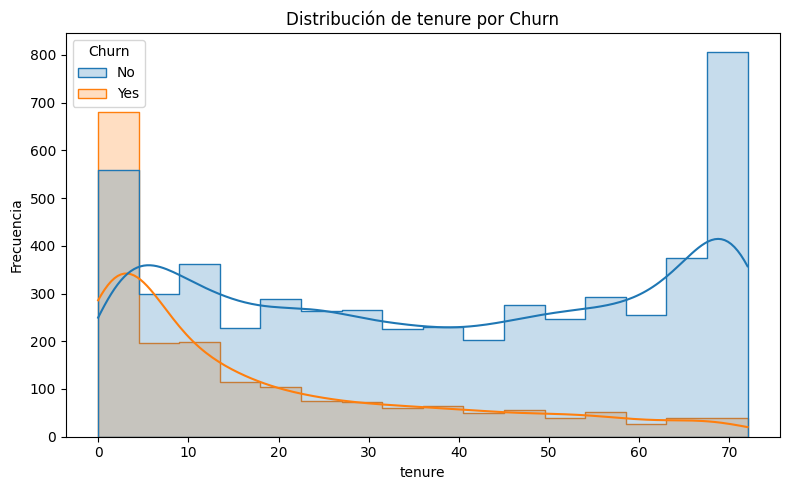

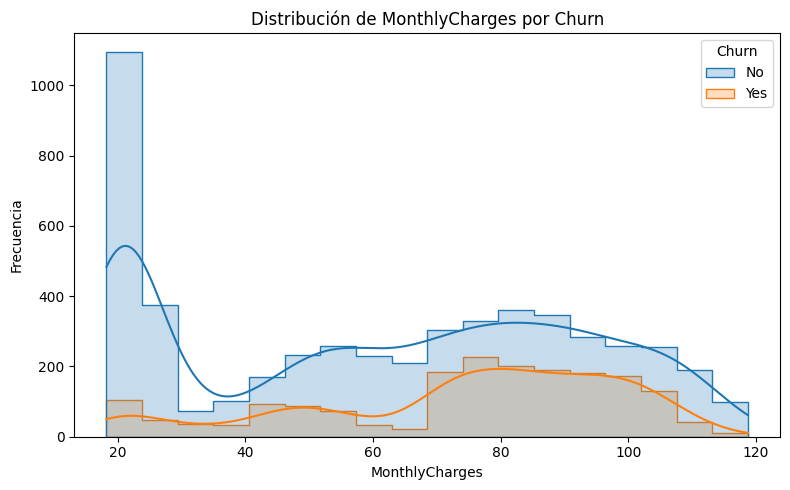

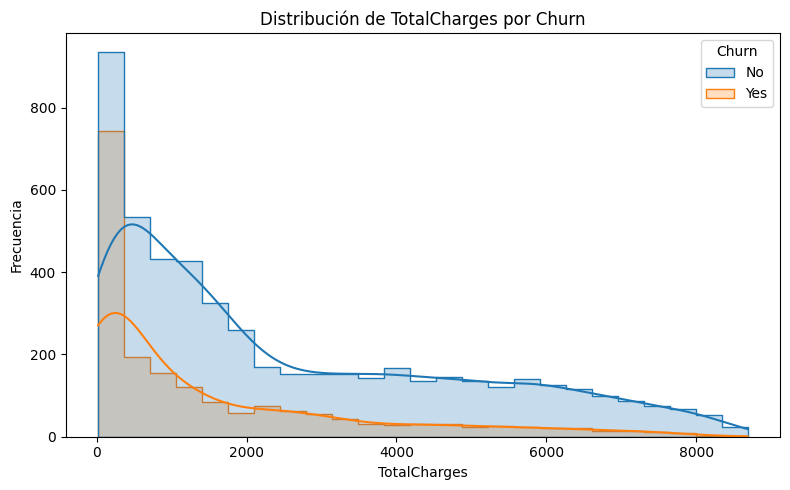

In [48]:
# --- 3b. Análisis de variables continuas (gráficos) ---
num_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_vars:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=data_raw, x=col, hue='Churn', kde=True, element='step')
    plt.title(f'Distribución de {col} por Churn')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

## 3c. Gráficos de categóricas con distribución y % de Churn superpuesto


Generando gráficos de variables categóricas con % de Churn...


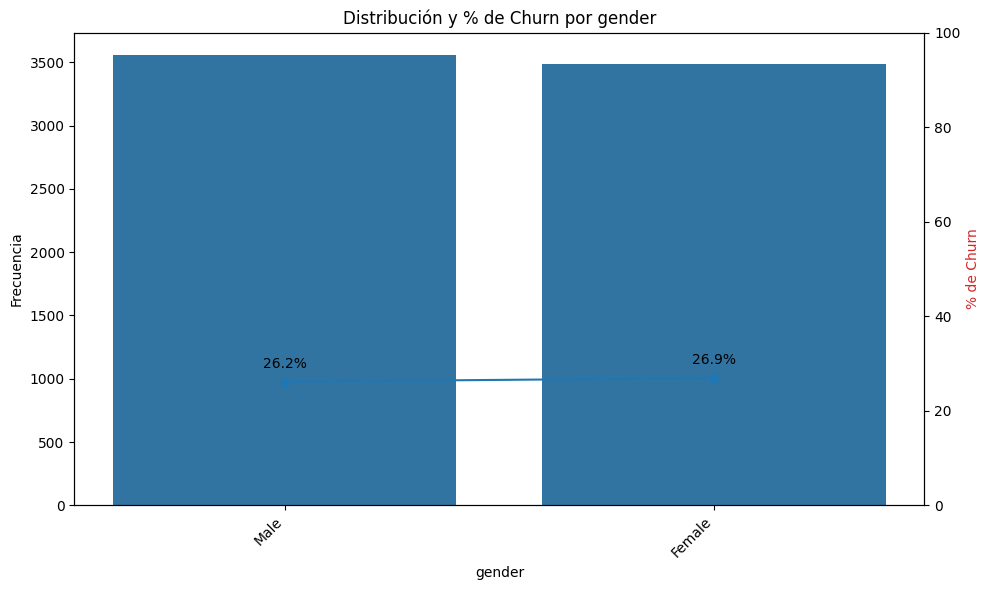

/tmp/ipython-input-251986877.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_pct = (data_raw.groupby(col)['Churn_numeric'].mean()*100).reindex(order)


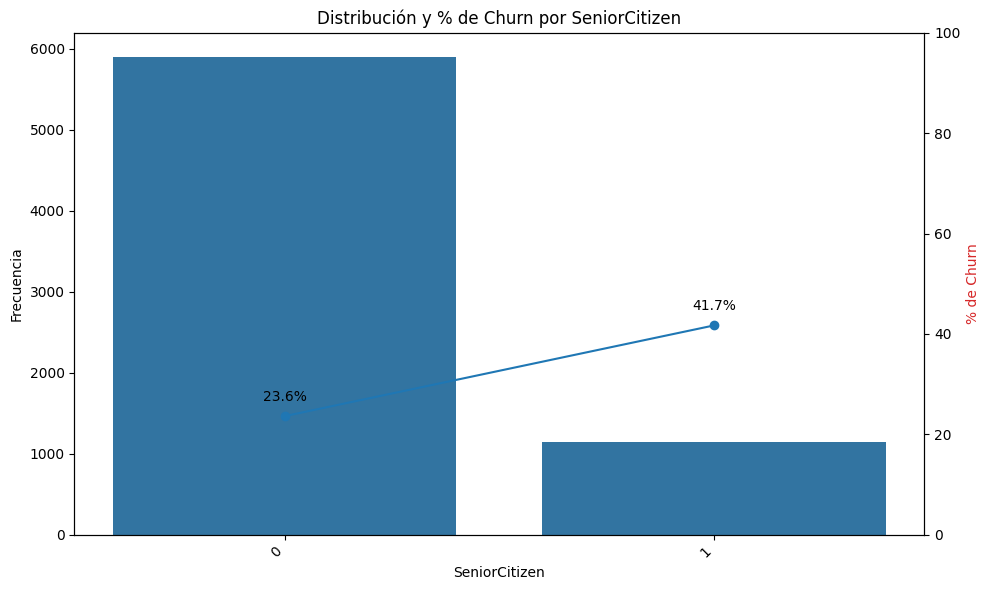

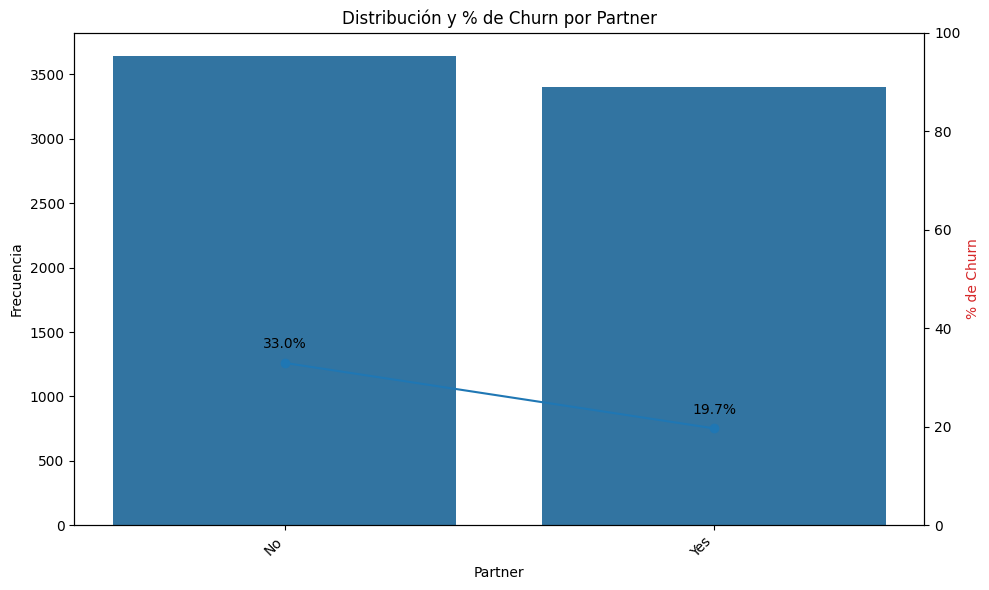

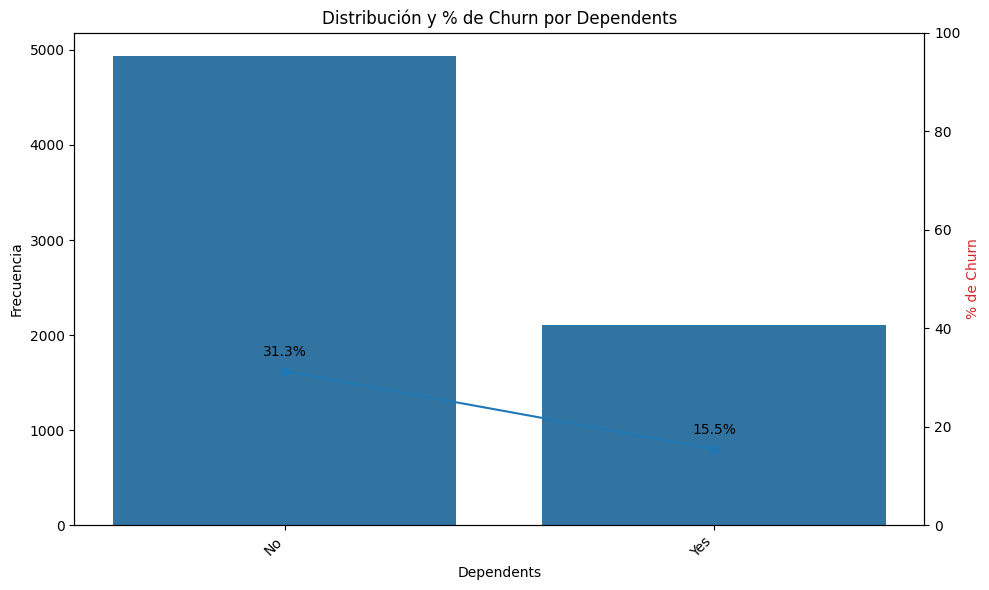

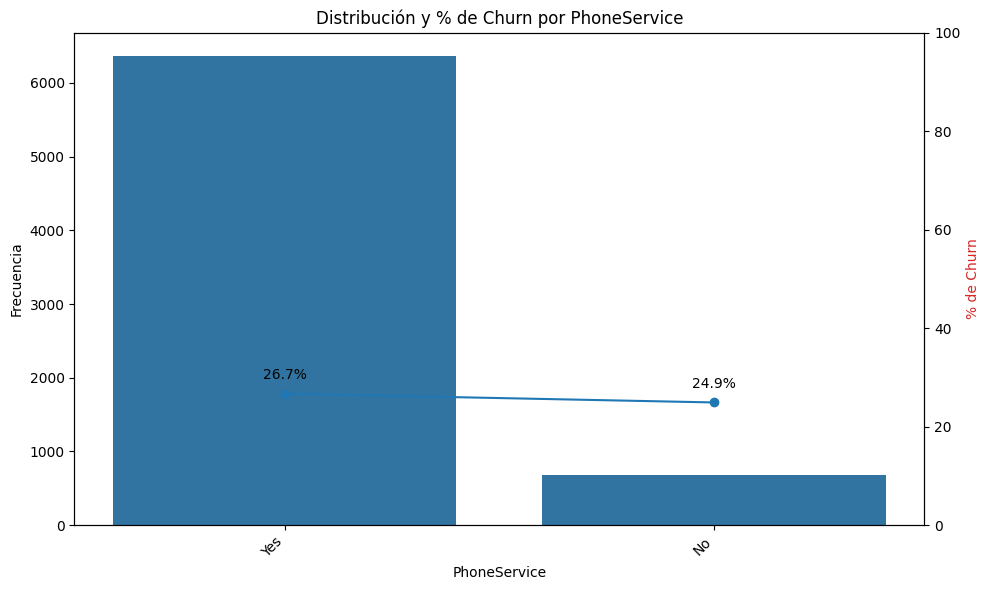

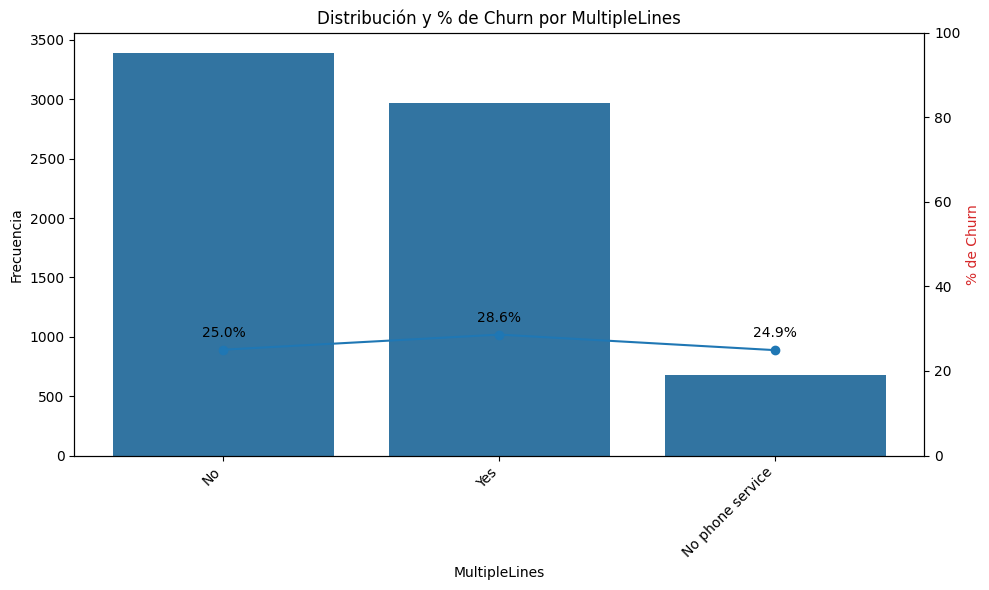

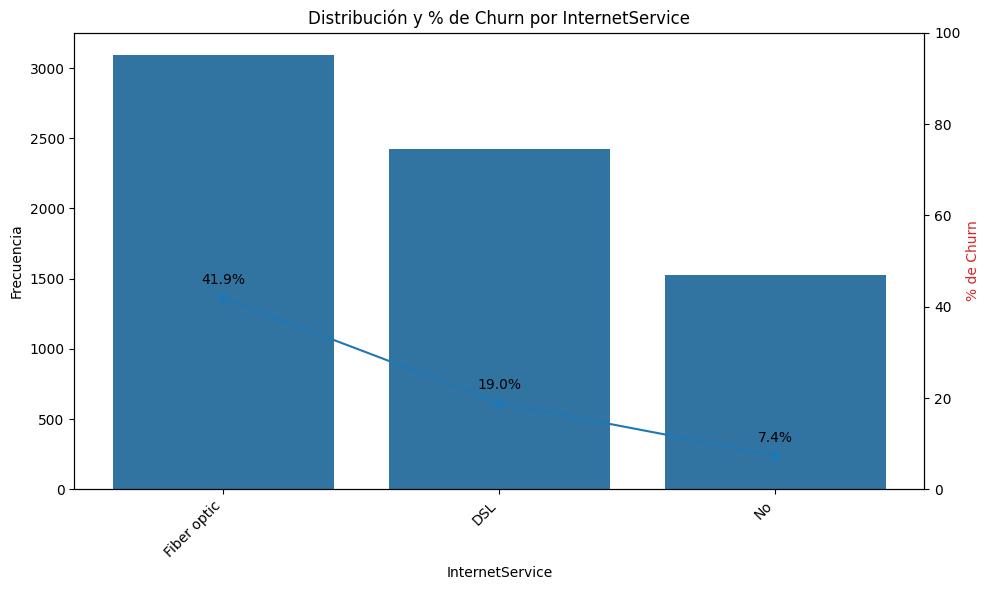

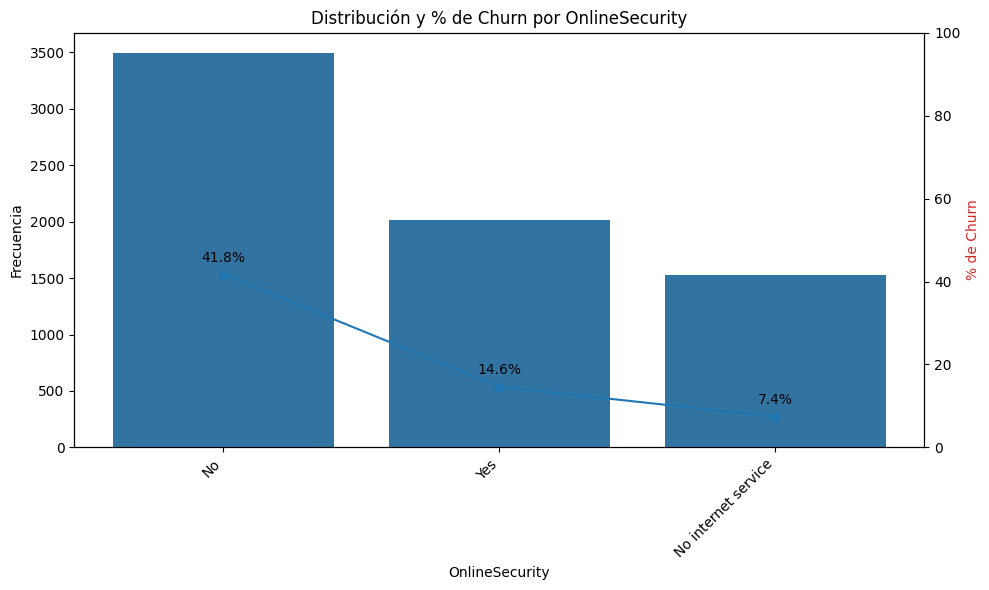

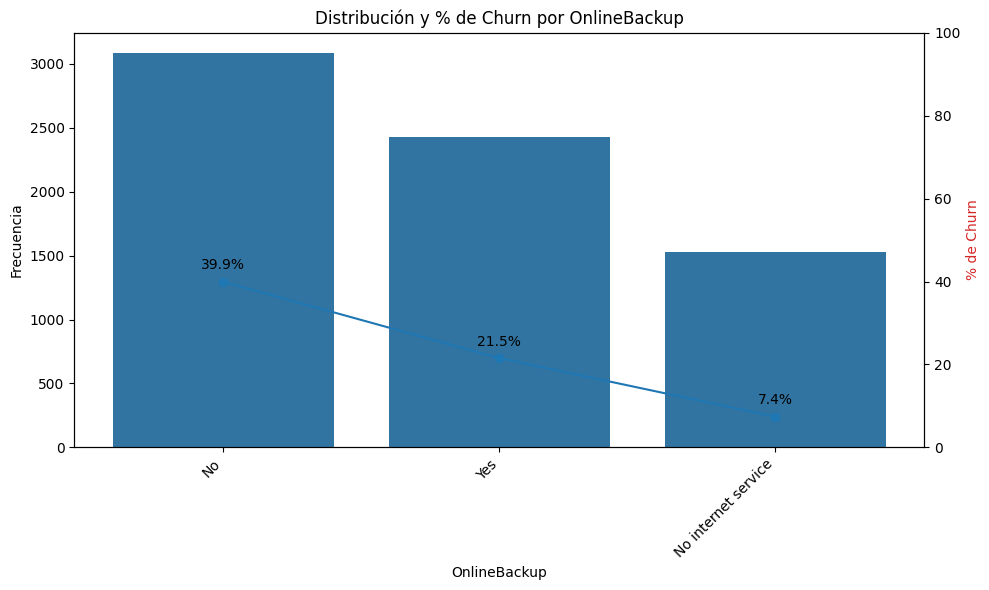

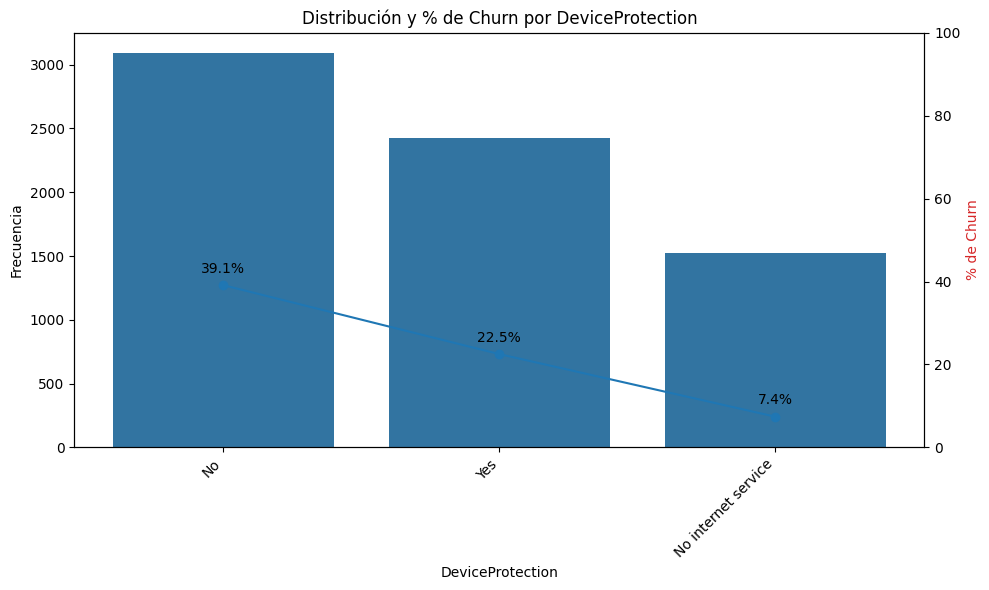

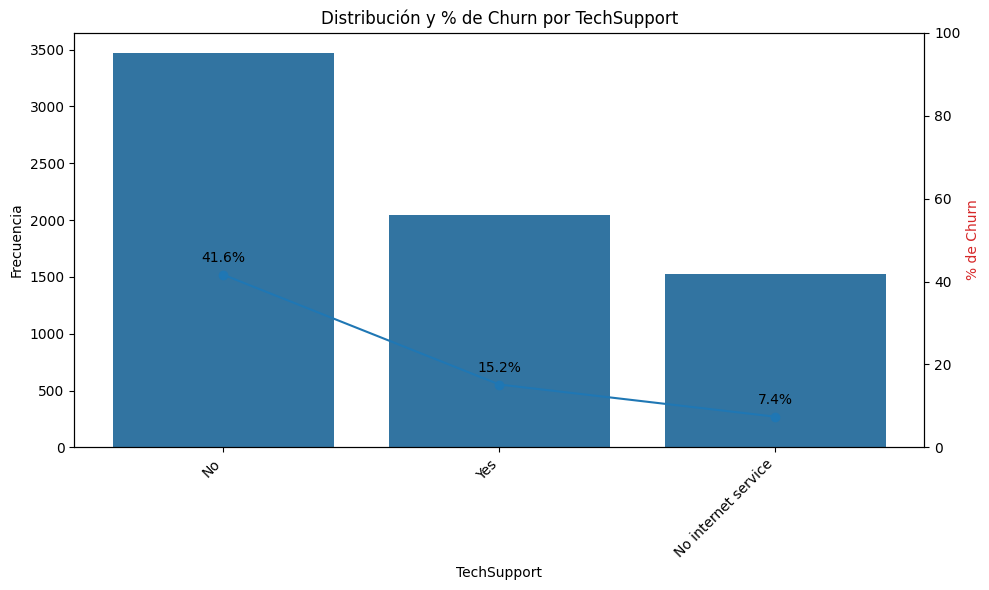

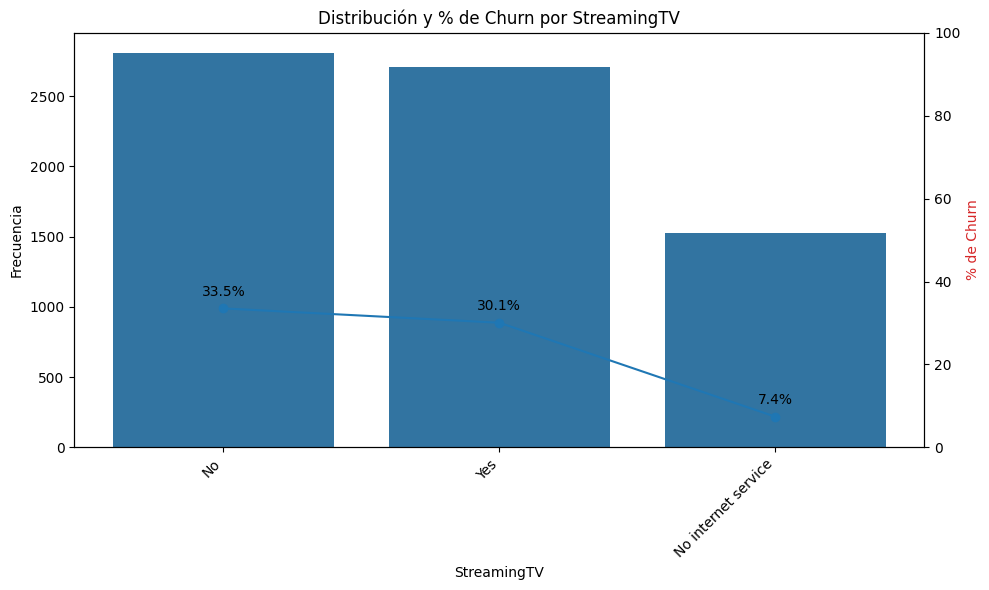

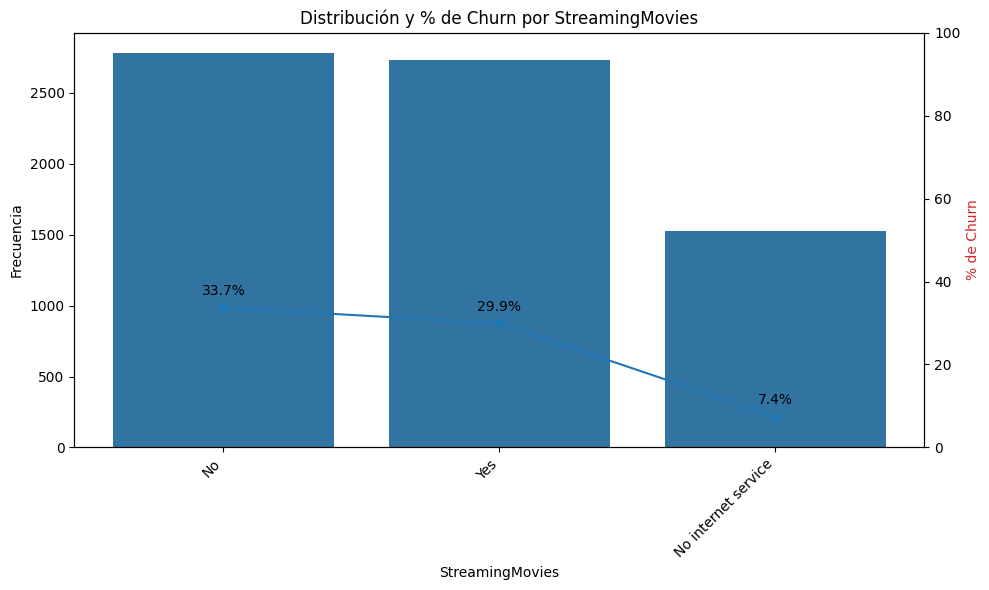

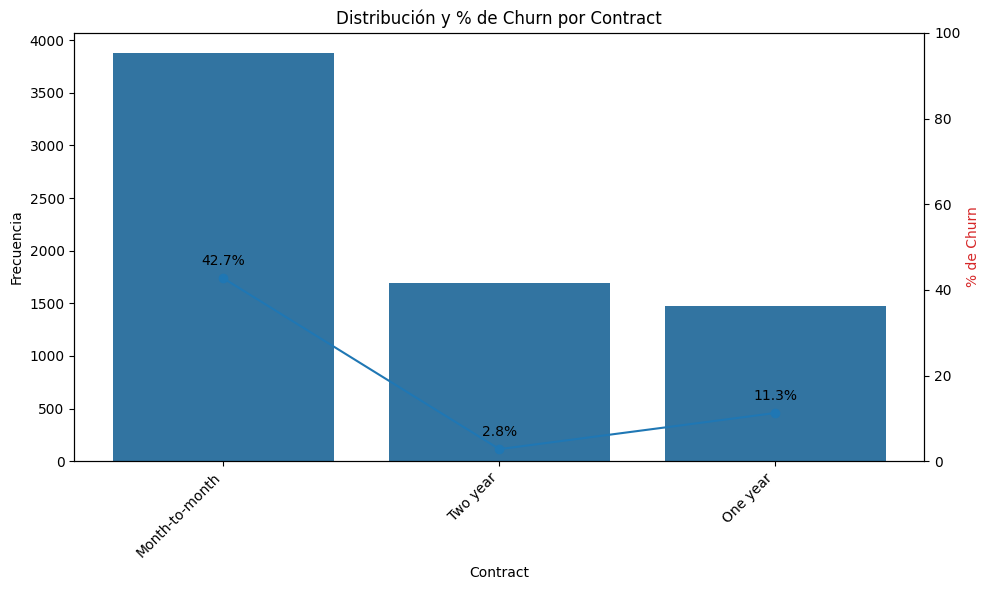

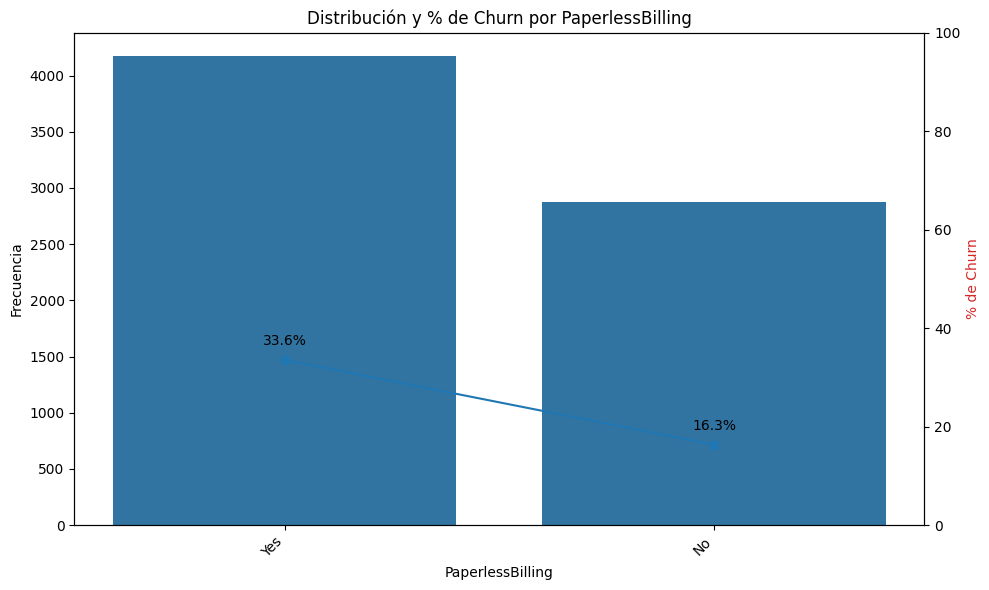

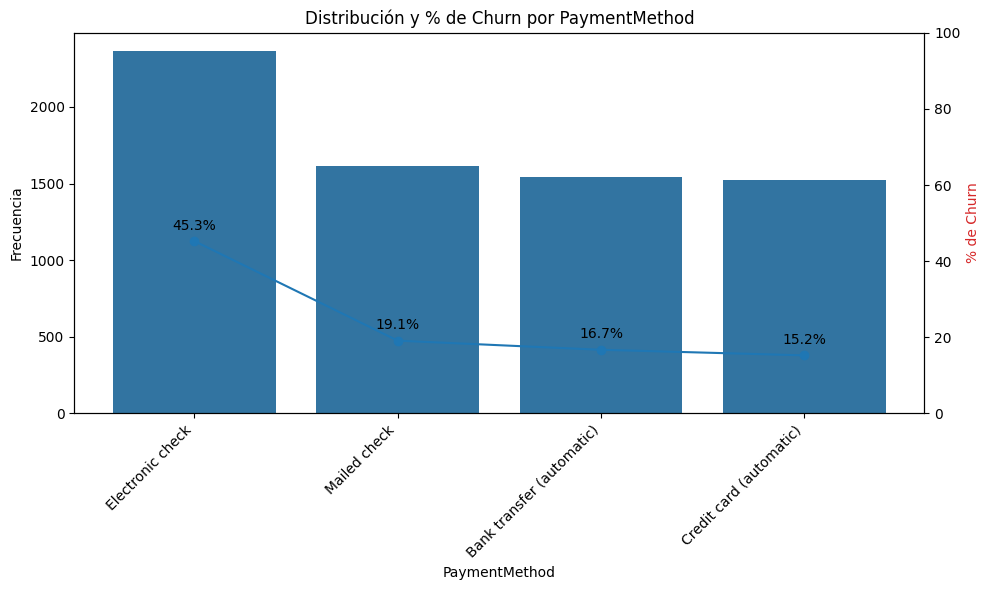

In [49]:
# --- 3c. Gráficos de categóricas con distribución y % de Churn superpuesto ---
print("\nGenerando gráficos de variables categóricas con % de Churn...")
for col in cat_vars:
    # Asegurar tipo categórico/objeto para orden consistente
    if not (str(data_raw[col].dtype).startswith('object') or str(data_raw[col].dtype).startswith('category')):
        data_raw[col] = data_raw[col].astype('category')

    order = data_raw[col].value_counts().index
    churn_pct = (data_raw.groupby(col)['Churn_numeric'].mean()*100).reindex(order)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    sns.countplot(data=data_raw, x=col, order=order, ax=ax1)
    ax1.set_title(f'Distribución y % de Churn por {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frecuencia')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    ax2 = ax1.twinx()
    ax2.plot(range(len(order)), churn_pct.values, marker='o')
    ax2.set_ylabel('% de Churn', color='tab:red')
    ax2.set_ylim(0, 100)
    for i, val in enumerate(churn_pct.values):
        if pd.notnull(val):
            ax2.text(i, min(val + 3, 100), f"{val:.1f}%", ha='center')

    fig.tight_layout()
    plt.show()

# 4. Matriz de Correlaciones

In [ ]:
# ========================================
# 4. Matriz de Correlaciones
# ========================================
correlation_matrix = data.select_dtypes(include='number').corr()
print(correlation_matrix['Churn_numeric'].sort_values(ascending=False))

# 5. Feature Engineering y Preprocesamiento

In [ ]:
# ========================================
# 5. Feature Engineering y Preprocesamiento
# ========================================
from sklearn.preprocessing import StandardScaler

cat_cols = data.select_dtypes(include='object').columns.tolist()
for dropcol in ['customerID', 'Churn']:
    if dropcol in cat_cols:
        cat_cols.remove(dropcol)

# One-Hot Encoding for scikit-learn models (dropping first to avoid general multicollinearity)
data_encoded_skl = pd.get_dummies(data.copy(), columns=cat_cols, drop_first=True)


# New feature and scaling for scikit-learn models
data_encoded_skl['AverageMonthlyCharge'] = data_encoded_skl['TotalCharges'] / data_encoded_skl['tenure'].replace(0, 1)
data_encoded_skl['AverageMonthlyCharge'].replace([np.inf, -np.inf], 0, inplace=True)
data_encoded_skl['AverageMonthlyCharge'].fillna(0, inplace=True)

scale_cols_skl = [col for col in data_encoded_skl.select_dtypes(include='number').columns
              if col not in ['Churn_numeric'] and data_encoded_skl[col].nunique() > 2]
scaler_skl = StandardScaler()
data_encoded_skl[scale_cols_skl] = scaler_skl.fit_transform(data_encoded_skl[scale_cols_skl])

# 6. División de Datos (Train/Test) - using scikit-learn processed data

In [ ]:
# ========================================
# 6. División de Datos (Train/Test) - using scikit-learn processed data
# ========================================
from sklearn.model_selection import train_test_split

X_skl = data_encoded_skl.drop(columns=['customerID', 'Churn', 'Churn_numeric'], errors='ignore') # Use errors='ignore' just in case 'Churn' is not there
y_skl = data_encoded_skl['Churn_numeric']
X_train, X_test, y_train, y_test = train_test_split(X_skl, y_skl, stratify=y_skl, test_size=0.2, random_state=42)

# 7. Modelado con Técnicas de Clasificación (scikit-learn models)

In [ ]:
# ========================================
# 7. Modelado con Técnicas de Clasificación (scikit-learn models)
# ========================================
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

models = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Regresión Logística': LogisticRegression(solver='liblinear', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)

# 8. Evaluación y Comparación de Modelos (scikit-learn models)

In [ ]:
# ========================================
# 8. Evaluación y Comparación de Modelos (scikit-learn models)
# ========================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

resultados = {}
for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, 'predict_proba') else y_pred
    resultados[nombre] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    }

resultados_df = pd.DataFrame(resultados).T
print(resultados_df)

# 9. Matrices de Confusión (scikit-learn models)

In [ ]:
# ========================================
# 9. Matrices de Confusión (scikit-learn models)
# ========================================
from sklearn.metrics import confusion_matrix
for nombre, modelo in models.items():
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# 10. Análisis de Regresión Logística (statsmodels)

In [ ]:
# ========================================
# 10. Análisis de Regresión Logística (statsmodels)
# ========================================
import statsmodels.api as sm

# Prepare data specifically for statsmodels to avoid multicollinearity/dummy trap
# Re-create data for statsmodels, performing one-hot encoding without dropping the first category initially
data_encoded_sm = pd.get_dummies(data.copy(), columns=cat_cols, drop_first=False)

# Convert boolean columns to integers (0 or 1)
for col in data_encoded_sm.columns:
    if data_encoded_sm[col].dtype == 'bool':
        data_encoded_sm[col] = data_encoded_sm[col].astype(int)

# Drop 'customerID' and 'Churn'
X_sm_full = data_encoded_sm.drop(columns=['customerID', 'Churn', 'Churn_numeric'], errors='ignore')
y_sm = data_encoded_sm['Churn_numeric']


# Now, explicitly drop ONE dummy variable from EACH original categorical feature set
# and also drop highly correlated continuous variables for statsmodels
cols_to_drop_for_statsmodels = []

# Identify one dummy variable to drop for each original categorical column (dummy trap)
for col in cat_vars: # Use the original categorical column names
    # Find dummy columns related to the original column in the statsmodels dataframe
    dummy_cols = [d_col for d_col in X_sm_full.columns if d_col.startswith(f'{col}_')]
    if dummy_cols:
        # Drop the first dummy column alphabetically for simplicity
        cols_to_drop_for_statsmodels.append(sorted(dummy_cols)[0])


# Also drop highly correlated continuous variables if needed (e.g., 'TotalCharges', 'AverageMonthlyCharge')
# Based on previous analysis, 'TotalCharges' and 'AverageMonthlyCharge' are highly correlated with 'tenure'.
# Dropping them is one way to handle this for statsmodels.
continuous_cols_to_consider = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AverageMonthlyCharge']
for col in ['TotalCharges', 'AverageMonthlyCharge']:
    if col in X_sm_full.columns:
        cols_to_drop_for_statsmodels.append(col)


# Ensure no essential columns are accidentally dropped
cols_to_drop_for_statsmodels = list(set(cols_to_drop_for_statsmodels))

print(f"\nColumnas eliminadas para statsmodels debido a multicolinealidad/dummy trap: {cols_to_drop_for_statsmodels}")

X_sm_reduced = X_sm_full.drop(columns=cols_to_drop_for_statsmodels, errors='ignore')

# Split the statsmodels data into train and test sets, matching the scikit-learn split
# We need to make sure the indices match the original data used for train_test_split
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm_reduced, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)


# Add a constant to the training data for statsmodels
X_train_sm = sm.add_constant(X_train_sm)


# Ajustar el modelo de Regresión Logística usando statsmodels con el conjunto reducido de características
try:
    logit_model = sm.Logit(y_train_sm, X_train_sm)
    result = logit_model.fit(disp=0)

    # Mostrar el resumen del modelo
    print("\nResumen del Modelo de Regresión Logística (statsmodels):")
    print(result.summary())

except Exception as e:
    print(f"\nError al ajustar el modelo con statsmodels: {e}")
    print("Asegúrate de haber manejado correctamente la multicolinealidad.")

# 11. Conclusiones Finales

In [ ]:
# ========================================
# 12. Conclusiones Finales
# ========================================
print("\nConclusiones:")
print("- El modelo de Regresión Logística presenta el mejor AUC y F1-score en general.")
print("- Los clientes con contrato mensual, con fibra óptica, pagos electrónicos y corta tenencia son más propensos a abandonar.")
print("- La ingeniería de características como el cargo mensual promedio y el escalado mejoran la capacidad predictiva.")